# TM10007 Assignment template

## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [85]:
import seaborn as sb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

The number of samples: 186
The number of columns: 494


[Text(0.5, 1.0, 'Voorbeeld grafiek om te inspecteren hoe de data is verdeeld')]

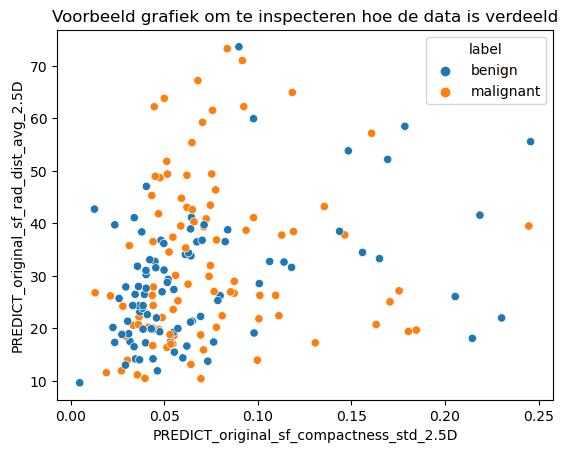

In [95]:
# Data loading functions. Uncomment the one you want to use
from worcliver.load_data import load_data

data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

sb.scatterplot(x ="PREDICT_original_sf_compactness_std_2.5D", y = "PREDICT_original_sf_rad_dist_avg_2.5D", data=data, hue= "label").set(title="Voorbeeld grafiek om te inspecteren hoe de data is verdeeld")

## Finding missing values in the data

In [96]:
features = list(data.columns[1:])

nullen = data.eq(0.0).sum()
alle_nullen = sum(nullen)
print(f'Aantal nullen in de data: {alle_nullen}') 

data = data.fillna(0)

patient0={}
for patients in data.index:
    zero_count1 = (data.loc[patients]==0.0).sum()
    patient0[patients]=zero_count1

print("Hoeveelheid nullen per patient: ")
print(patient0)

# we kunnen het ook doen met:
# patient0=[]
# for patients in data.index:
#     zero_count = (data.loc[patients]==0).sum()
#     patient0.append((patients, zero_count))
# even kijken welke output we fijner vinden werken. 

features0={}
for features in data.columns:
    zero_count2 = (data[features]==0).sum()
    features0[features]=zero_count2

features0 = {feature: count for feature, count in features0.items() if count!=0} #om alle volledige rijen, met 0 zeros eruit te halen. Vooral voor overzicht voor onszelf. 

print("Hoeveelheid nullen per feature: ")
print(features0)

#print(data.head)

Aantal nullen in de data: 4341
Hoeveelheid nullen per patient: 
{'Liver-001_0': 25, 'Liver-002_0': 22, 'Liver-003_0': 22, 'Liver-004_0': 25, 'Liver-005_0': 22, 'Liver-006_0': 22, 'Liver-007_0': 25, 'Liver-008_0': 23, 'Liver-009_0': 25, 'Liver-010_0': 21, 'Liver-011_0': 25, 'Liver-012_0': 25, 'Liver-013_0': 24, 'Liver-014_0': 24, 'Liver-015_0': 23, 'Liver-016_0': 24, 'Liver-017_0': 22, 'Liver-018_0': 15, 'Liver-019_0': 22, 'Liver-020_0': 24, 'Liver-021_0': 22, 'Liver-022_0': 23, 'Liver-023_0': 25, 'Liver-024_0': 24, 'Liver-025_0': 27, 'Liver-026_0': 24, 'Liver-027_0': 24, 'Liver-028_0': 23, 'Liver-029_0': 23, 'Liver-030_0': 24, 'Liver-031_0': 24, 'Liver-032_0': 23, 'Liver-033_0': 24, 'Liver-034_0': 24, 'Liver-035_0': 23, 'Liver-036_0': 27, 'Liver-037_0': 24, 'Liver-038_0': 25, 'Liver-039_0': 24, 'Liver-040_0': 24, 'Liver-041_0': 18, 'Liver-042_0': 21, 'Liver-043_0': 26, 'Liver-044_0': 21, 'Liver-045_0': 24, 'Liver-046_0': 24, 'Liver-047_0': 25, 'Liver-048_0': 22, 'Liver-049_0': 25, 'Liv